# Kernel density estimation

Tests on the titanic dataset.

In [26]:
import pandas as pd
import numpy as np
import scipy
import sampyl as smp
import seaborn as sns
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [27]:
train = pd.read_csv('./datasets/titanic_train.csv')
test  = pd.read_csv('./datasets/titanic_test.csv')

### Data preparation + modeling

In [29]:
data = pd.concat([train, test])

data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

data.Sex, mapper_sex      = pd.factorize(data.Sex)
data.Embarked, mapper_emb = pd.factorize(data.Embarked)

to_drop = ['PassengerId', 'Ticket', 'Cabin', 'Name']# 'Embarked', 'Pclass', 'Parch', 'Sex', 'SibSp']
data.drop(to_drop, axis=1, inplace=True)

maxs = data.drop("Survived", axis=1).max()

data.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,0,7.2500,0,3,0,1,0.0
1,38.0,1,71.2833,0,1,1,1,1.0
2,26.0,0,7.9250,0,3,1,0,1.0
3,35.0,0,53.1000,0,1,1,1,1.0
4,35.0,0,8.0500,0,3,0,0,0.0


In [30]:
# Normalizing
cont = ['Age', 'Fare']
cate = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

normalized = data.copy()
#normalized[cont] = (normalized[cont] - normalized[cont].mean()) / normalized[cont].std()

train = normalized[~normalized.Survived.isnull()]
test = normalized[normalized.Survived.isnull()].drop("Survived", axis=1)

In [31]:
train_x = train.drop('Survived', axis=1)
train_y = train.Survived

rf = RandomForestClassifier(n_estimators=250)
rf.fit(train_x, train_y)

preds = rf.predict(test)

### Kernel density estimation

In [77]:
X = test.mode().loc[0]
X

Age         28.00
Embarked     0.00
Fare         7.75
Parch        0.00
Pclass       3.00
Sex          0.00
SibSp        0.00
Name: 0, dtype: float64

# Sample from unknown - then KDE

In [78]:
rf.predict_proba([X.values])[0,1]

0.31312307692307689

In [79]:
# To use automatic gradient calculations, use numpy (np) provided
# by autograd through Sampyl

#icov = np.linalg.inv(np.array([[1., .8], [.8, 1.]]))

N_obs = 10000

def logp(Age, Embarked, Fare, Parch, Pclass, Sex, SibSp):
    Embarked = np.floor(Embarked).astype(int)
    Parch = np.floor(Parch).astype(int)
    Pclass = np.floor(Pclass).astype(int)
    Sex = np.floor(Sex).astype(int)
    SibSp = np.floor(SibSp).astype(int)
        
    d = np.array([Age, Embarked, Fare, Parch, Pclass, Sex, SibSp])
    #d = np.array([Age, Fare])
    
    if (d > maxs).any() or (d < 0).any():
        return -np.infty

    return np.log(1 - rf.predict_proba([d])[0,1])

start = X.to_dict()
metro_hast = smp.Metropolis(logp, start)
chain = metro_hast.sample(N_obs)

Progress: [###########-------------------] 3508 of 10000 samples

/Users/marcbeillevaire/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log


Progress: [##############################] 10000 of 10000 samples


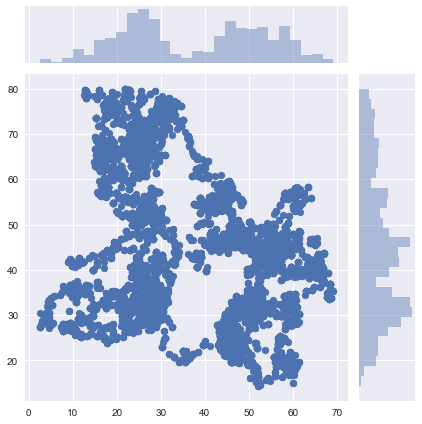

In [80]:
sns.jointplot(chain.Fare, chain.Age, stat_func=None)

### Kernel density estimation

In [67]:
n_dim = X.shape[0]

smpld = chain.view((np.float, n_dim))

In [68]:
density = KDEMultivariate(data=smpld, var_type='c' * n_dim, bw='normal_reference')
bw = density.bw

In [69]:
def pdf_deriv(x, samples):
    coef =  1 / (N_obs * (np.sqrt(2 * np.pi)**n))
    mtrx = [-0.5 * sum((x - x_i) * (x - x_i) / (bw * bw)) for x_i in samples]
    deriv_vector = -0.5 * np.array([(x - x_i) / (bw * bw) for x_i in samples])

    return (coef * np.sum(np.exp(mtrx)) / np.prod(bw)) * np.sum(deriv_vector, axis=0)

def contribution(X, samples):
    contribs = pd.Series(pdf_deriv(X, samples), index=train_x.columns).sort_values()
    return contribs / contribs.sum()

In [71]:
ctrb = contribution(X, smpld)

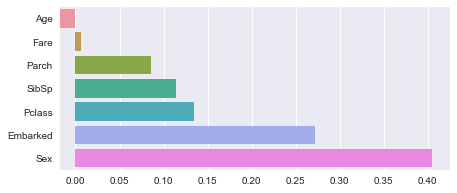

In [73]:
fig = sns.plt.figure(figsize=(7, 3))

sns.barplot(ctrb.values, ctrb.index)

fig.savefig('../report/img/1-2-1.svg')